# 강아지 고양이 분류 - CNN v2
- 부분 데이터 
    - 훈련 : 개 1000장 / 고양이 1000장
    - 평가 : 개 500장 / 고양이 500장
- 이미지 센터링 처리 함

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-05-24 07:12:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.212.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   213MB/s    in 0.3s    

2022-05-24 07:12:01 (213 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

## 데이터 탐색
- 이미지 축소, 확대 및 센터링해서 반환하는 함수

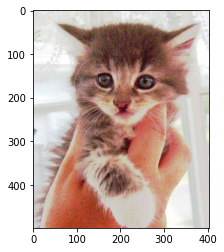

In [4]:
import cv2
img_size = 150
fname = 'cats_and_dogs_filtered/train/cats/cat.100.jpg'
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(img)

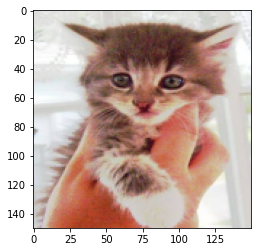

In [5]:
plt.imshow(cv2.resize(img, dsize = (150, 150), interpolation = cv2.INTER_AREA));

In [6]:
h, w, _ = img.shape
h, w

(499, 403)

In [27]:
if h > w:
    height, width = (h * img_size)//w , img_size
else:
    width, height = (h * img_size)//w , img_size

In [29]:
# Pillow image = new_img() tq
new_img = cv2.resize(img, dsize = (width, height), interpolation = cv2.INTER_AREA)
new_img.shape

(185, 150, 3)

In [33]:
diff = abs(width - height) // 2
if h > w:
    final_img = new_img[diff : diff + img_size, :]
else:
    final_img = new_img[:, diff : diff + img_size]

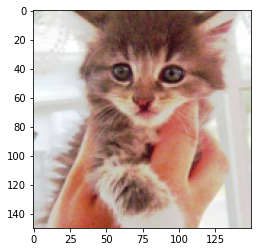

In [34]:
plt.imshow(final_img);

In [7]:
def center_image(img, src_format = 'OpenCV', dst_format = 'OpenCV'):
    if src_format == 'OpenCV':
        h, w = img.shape[:-1]
    else: # pillow
        h, w = np.array(img).shape[:-1]

    img_size = 150
    if h > w:
        height, width = (h * img_size)//w , img_size
    else:
        width, height = (w * img_size)//h , img_size
    
    inter = cv2.INTER_AREA if h + w > 300 else cv2.INTER_CUBIC
    new_img = cv2.resize(img, dsize = (width, height), interpolation = inter)

    diff = abs(width - height) // 2
    if h > w:
        final_img = new_img[diff : diff + img_size, :]
    else:
        final_img = new_img[:, diff : diff + img_size]

    return final_img if dst_format == 'OpenCV' else Image.fromarray(final_img)

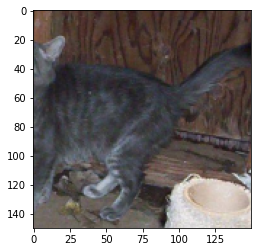

In [8]:
fname = 'cats_and_dogs_filtered/train/cats/cat.22.jpg'
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(center_image(img));

In [9]:
CENTER_DIR = 'cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [10]:
import os
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

In [11]:
old_train_cats_dir = 'cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [12]:
from glob import glob
from PIL import Image

for src_dir in [old_train_cats_dir, old_train_dogs_dir, old_validation_cats_dir, old_validation_dogs_dir]:
    # dst_dir = src_dir.split('/')[1:]
    # dst_dir = '/'.join([CENTER_DIR] + dst_dir)
    dst_dir = src_dir.replace('filtered', 'centered')
    for fname in glob(f'{src_dir}/*.jpg'):
        dst_fname = fname.split('/')[-1]
        src_img = cv2.imread(fname)[:,:,::-1]
        dst_img = center_image(src_img, src_format = 'OpenCV', dst_format = 'Pillow')
        dst_img.save(f'{dst_dir}/{dst_fname}')

In [13]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.264.jpg', 'cat.708.jpg', 'cat.381.jpg', 'cat.37.jpg', 'cat.281.jpg']
['dog.28.jpg', 'dog.874.jpg', 'dog.140.jpg', 'dog.862.jpg', 'dog.290.jpg']


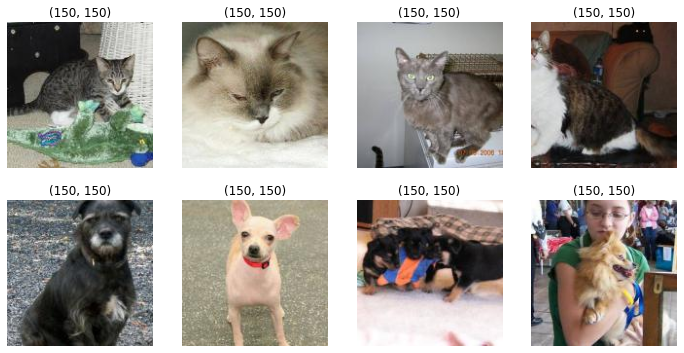

In [14]:
plt.figure(figsize = (12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i + 5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])


## 모델 구성 및 설정

In [15]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
model = Sequential([
    Conv2D(16, (3, 3), input_shape = (150, 150, 3), activation = 'relu'),
    MaxPooling2D(), # (148, 148, 16) -> (74, ..)
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation = 'relu'),
    #Dropout(0.25),
    Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [17]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate = 0.01, decay = 1e-8), 
                loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
model_path = 'best-cats-dogs-cnn-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 10)

### 파일에서 이미지를 읽어서 학습시키는 방법

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1 / 255.) # minmax scaler 효과
test_datagen = ImageDataGenerator(rescale = 1 / 255.)

In [21]:
train_generater = train_datagen.flow_from_directory(
    train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150)
)
test_generater = test_datagen.flow_from_directory(
    validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
hist = model.fit(
    train_generator, 
    validation_data=test_generator,
    epochs=100, steps_per_epoch=100,
    validation_steps=50, callbacks=[mc, es]
)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 23.3695 - accuracy: 0.5131
Epoch 1: val_loss improved from inf to 0.69068, saving model to best-cats-dogs-cnn-v2.h5
100/100 [==============================] - 17s 38ms/step - loss: 23.1427 - accuracy: 0.5130 - val_loss: 0.6907 - val_accuracy: 0.5670
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.5010
Epoch 2: val_loss did not improve from 0.69068
100/100 [==============================] - 3s 34ms/step - loss: 0.7407 - accuracy: 0.5010 - val_loss: 0.7781 - val_accuracy: 0.5000
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.9795 - accuracy: 0.5190
Epoch 3: val_loss did not improve from 0.69068
100/100 [==============================] - 4s 35ms/step - loss: 0.9795 - accuracy: 0.5190 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.5150
Epoch 4: val_loss did not impr

In [25]:
best_model = load_model(model_path)

## 테스트 이미지 분류

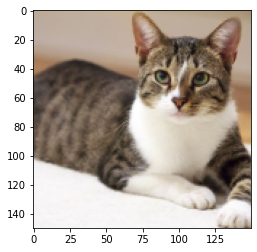

In [26]:
img = cv2.imread('고양이.jpg')[:,:,::-1]
plt.imshow(center_image(img));

In [31]:
# (150, 150, 3)의 3차원을 4차원으로 넣어줘야됨
best_model.predict(center_image(img).reshape(1, 150, 150, 3))

array([[0.48201284]], dtype=float32)

In [32]:
%cd /content/

/content


In [33]:
os.listdir('/content')
lst = ['고양이2.jfif',
 '고양이.jpg',
 '개.jpg',
 '고양이1.jpg',
 '개2.jpg']

In [34]:
for fname in lst:
    img = cv2.imread(fname)[:,:,::-1]   # 이미지 읽어오기
    # 큰 그림 줄이기
    if sum(img.shape[:-1]) > 300:
        img = cv2.resize(img, dsize = (150, 150), interpolation = cv2.INTER_AREA)   
    # 작은 그림 늘리기
    else:
        img = cv2.resize(img, dsize = (150, 150), interpolation = cv2.INTER_CUBIC)   

    classes = best_model.predict(img.reshape(1, 150, 150, 3))
    print(f"{fname.split('.')[0]} 은 {classes[0][0]:.4f}로 예측됨.")


고양이2 은 0.4820로 예측됨.
고양이 은 0.4820로 예측됨.
개 은 1.0000로 예측됨.
고양이1 은 0.4820로 예측됨.
개2 은 0.4820로 예측됨.
